# CSc 44800 – Artificial Intelligence, Fall 2025  
## Final Project: AI Wellness Assistant

Name: Sehr Abrar  
EMPLID: 24123078  
Email: sabrar000@citymail.cuny.edu  
Submission Date: December 18, 2025  
Collaboration: None  

---

# Project Overview

## Introduction
This project aims to build an AI Wellness Assistant that identifies emotions in text and generates short, supportive responses. It consists of two components: an emotion classifier and a response generator. The goal is to explore how AI can assist with emotional well-being in a simple, safe way.

## Dataset
The project uses the GoEmotions dataset, a collection of 58,009 Reddit comments labeled with 27 emotion categories plus Neutral. This project uses the raw CSV files, combines them, and prepares a cleaned version with a single dominant emotion per example for training.

## Approach
1. **Data Preprocessing:** Clean and normalize text, remove noise, split into train/test sets.
2. **Exploratory Data Analysis:** Examine class balance, sample texts, and key patterns in the dataset.

3. **Model Development:** Train an emotion classifier using TF-IDF or GloVe embeddings; optionally compare with DistilBERT.

4. **Response Generation Module:** Create rule-based or template-based responses that take the predicted emotion and produce supportive output.

5. **System Integration & Demo:**  Connect the classifier to the response generator and demonstrate the full workflow on example inputs.


## Safety Considerations
Responses will be general and supportive. The system will avoid giving advice and will not act as a substitute for professional help.

## Goal
The end result will be a working prototype that classifies emotional text and generates appropriate supportive responses, demonstrating basic emotional NLP and model integration.

---

In [ ]:
!pip install emoji

In [ ]:
!pip install contractions

In [ ]:
## Step 0: Complete necessary libraries and packages for the project

import pandas as pd
import numpy as np
import re
import emoji
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

# 1. Data Preprocessing

In [ ]:
# Step 1: Load all 3 datasets into the notebook
df1 = pd.read_csv("goemotions_1.csv")
df2 = pd.read_csv("goemotions_2.csv")
df3 = pd.read_csv("goemotions_3.csv")

# Step 2: Combine them into one DataFrame
df_raw = pd.concat([df1, df2, df3], ignore_index=True)

# Step 3: Inspect the data
print("Columns:", df_raw.columns)
print("Shape:", df_raw.shape)
df_raw.head()

Columns: Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
Shape: (211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Step 4: Aggregate annotations by comment ID, each row currently represents one rater's annotation

# list of emotion columns (already defined)
emotion_cols = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise'
]

# group them by comment ID, sum annotations
df_grouped = df_raw.groupby("id").agg({
    'text': 'first',  # take the first copy of the comment
    **{col: 'sum' for col in emotion_cols}  # sum the rater votes
}).reset_index()

print("Grouped Shape:", df_grouped.shape)
df_grouped.head()

Grouped Shape: (58011, 29)


,id,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,eczb527,So much time saved. Not.,0,0,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0
4,eczb6r7,Emotes have a ridiculous amount of effort put ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Step 5: Filter comments with agreement (2 or more raters for at least one emotion)
df_clean = df_grouped[df_grouped[emotion_cols].max(axis=1) >= 2]
print("Filtered Shape (Agreement >=2):", df_clean.shape)

# Step 6: Assign a single dominant emotion per comment
df_clean['label'] = df_clean[emotion_cols].idxmax(axis=1)

# inspect the cleaned dataset
df_clean[['text','label']].head(10)

Filtered Shape (Agreement >=2): (38242, 29)


/tmp/ipython-input-3255367971.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['label'] = df_clean[emotion_cols].idxmax(axis=1)


,text,label
0,Fast as [NAME] will carry me. Seriously uptown...,approval
2,TL;DR No more Superbowls for [NAME]. Get ready...,disappointment
3,So much time saved. Not.,curiosity
5,Just life.. I feel like i'm just a parasite th...,embarrassment
6,Thanks for the advice man ! Have a great New Y...,gratitude
7,*they were not* 😂 perfect. I’m sure they were ...,amusement
8,Glad to hear it. You deserve your best life wi...,caring
10,Now this is poke choking!,disgust
11,I was AF enlisted too hahaha,joy
12,Happy New Year Everybody!,gratitude


In [ ]:
# Step 7: Text cleaning for emotion detection
try:
    import contractions
    use_contractions = True
except:
    use_contractions = False

def clean_text_emotion(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    if use_contractions:
        text = contractions.fix(text)  # expand contractions

    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"\[\w+\]", "<user>", text)    # replace [NAME] with <user>
    text = re.sub(r"\b\d+\b", "<num>", text)     # replace numbers with <num>
    text = emoji.demojize(text)                   # convert emojis to words
    text = text.replace(":", " ")                 # remove colons from emoji words
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)   # reduce repeated letters
    text = re.sub(r"[^a-z0-9!?.,;'\-()\[\]\s]", "", text)  # keep meaningful chars
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces

    return text

# apply the cleaning function
df_clean.loc[:, 'clean_text'] = df_clean['text'].apply(clean_text_emotion)

# inspect
df_clean[['text','clean_text','label']].head(10)


/tmp/ipython-input-1853567041.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'clean_text'] = df_clean['text'].apply(clean_text_emotion)


,text,clean_text,label
0,Fast as [NAME] will carry me. Seriously uptown...,fast as user will carry me. seriously uptown t...,approval
2,TL;DR No more Superbowls for [NAME]. Get ready...,tl;dr no more superbowls for user. get ready f...,disappointment
3,So much time saved. Not.,so much time saved. not.,curiosity
5,Just life.. I feel like i'm just a parasite th...,just life.. i feel like i am just a parasite t...,embarrassment
6,Thanks for the advice man ! Have a great New Y...,thanks for the advice man ! have a great new y...,gratitude
7,*they were not* 😂 perfect. I’m sure they were ...,they were not facewithtearsofjoy perfect. i am...,amusement
8,Glad to hear it. You deserve your best life wi...,glad to hear it. you deserve your best life wi...,caring
10,Now this is poke choking!,now this is poke choking!,disgust
11,I was AF enlisted too hahaha,i was af enlisted too hahaha,joy
12,Happy New Year Everybody!,happy new year everybody!,gratitude


# 2. Exploratory Data Analysis (EDA)

In [ ]:
# Step 1: Check the combined dataset size

print("Total Comments:", df_clean.shape[0])
print("Number of Emotion Classes:", df_clean['label'].nunique())

Total Comments: 38242
Number of Emotion Classes: 27


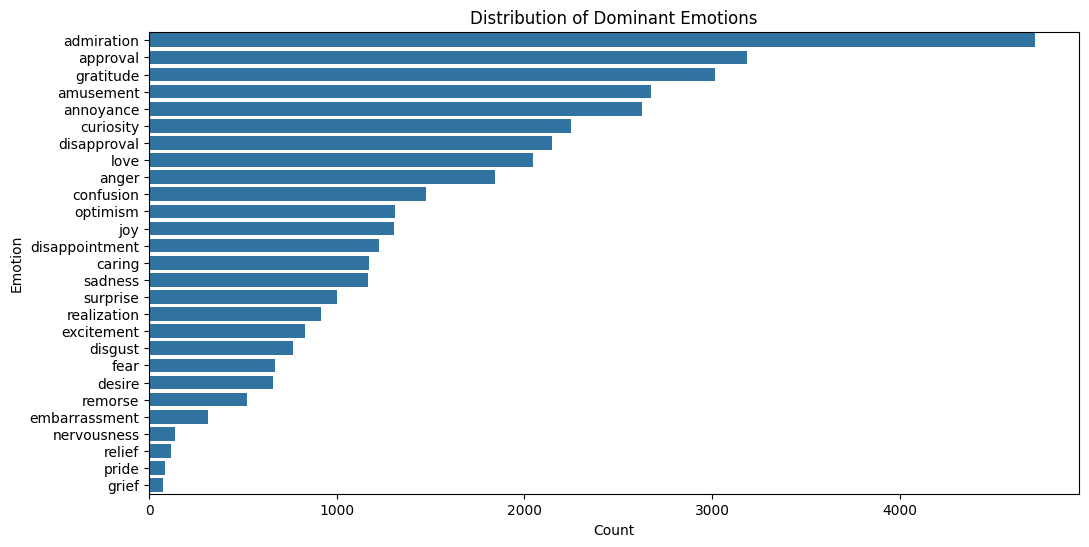

In [ ]:
# Step 2: Distribution of Emotions

plt.figure(figsize=(12,6))
sns.countplot(y='label', data=df_clean, order=df_clean['label'].value_counts().index)
plt.title("Distribution of Dominant Emotions")
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.show()

In [ ]:
# Step 3: Sample Comments per Emotion

# 3 example comments for a few emotions
sample_emotions = ['joy', 'sadness', 'anger', 'fear']
for emotion in sample_emotions:
    print(f"\nExamples of '{emotion}':")
    display(df_clean[df_clean['label']==emotion][['clean_text']].sample(3, random_state=1))



Examples of 'joy':


,clean_text
26283,i gave the show a chance because i enjoyed bad...
56990,so glad i moved here.
6851,"dude, you made my day."



Examples of 'sadness':


,clean_text
21953,it also makes me cry! but because it shows how...
14623,"due to work, got to stay legal. edibles are no..."
10120,if i died i have always wondered who will be a...



Examples of 'anger':


,clean_text
10703,good for you for shutting that door! you are n...
16355,so now disabled people do not have rights . yo...
7957,"i will kill you if you do that again, honey"



Examples of 'fear':


,clean_text
19084,this is really scary. the saddest about this i...
30857,that arena is so ugly i would be scared too
4043,i find that relatable i too am terrified of my...


Average text length: 13.522096124679672


/tmp/ipython-input-2284090678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['text_length'] = df_clean['clean_text'].apply(lambda x: len(x.split()))


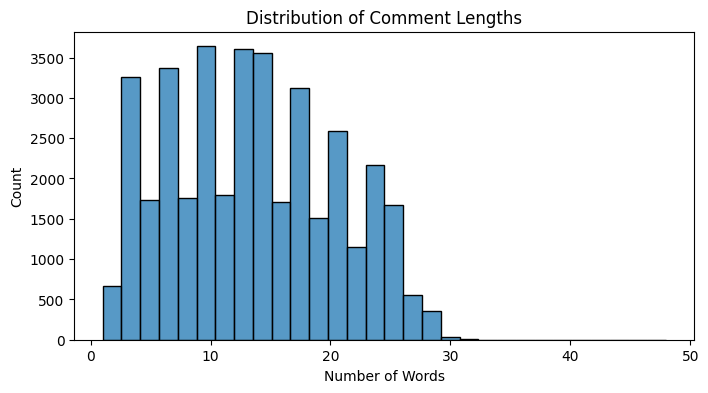

In [ ]:
# Step 4: Average Comment Length

df_clean['text_length'] = df_clean['clean_text'].apply(lambda x: len(x.split()))
print("Average text length:", df_clean['text_length'].mean())

plt.figure(figsize=(8,4))
sns.histplot(df_clean['text_length'], bins=30)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

In [ ]:
# Step 5: Common Words

all_words = " ".join(df_clean['clean_text']).split()
filtered_words = [w for w in all_words if w not in ENGLISH_STOP_WORDS]
word_counts = Counter(filtered_words)
word_counts.most_common(20)

[('user', 4599),
 ('just', 2998),
 ('like', 2844),
 ('love', 2193),
 ('num', 2130),
 ('good', 1657),
 ('did', 1524),
 ('really', 1414),
 ('thank', 1331),
 ('people', 1318),
 ('know', 1222),
 ('think', 1201),
 ('thanks', 1094),
 ('lol', 1019),
 ('it.', 968),
 ('going', 941),
 ('got', 928),
 ('does', 922),
 ('hope', 899),
 ('want', 778)]

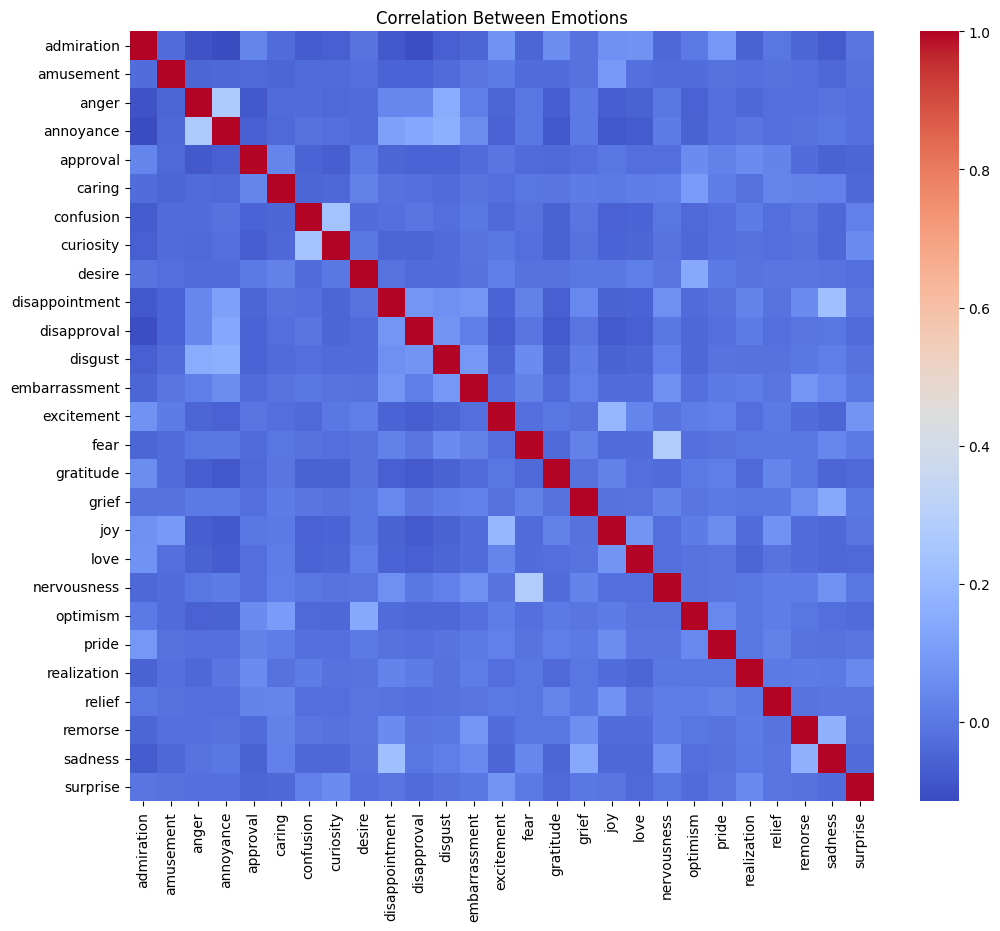

In [ ]:
# Step 6: Emotion Correlation Map

plt.figure(figsize=(12,10))
sns.heatmap(df_grouped[emotion_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Between Emotions")
plt.show()

In [ ]:
# Step 7: Top Words per Emotion

def top_words(df, emotion, n=10):
    # combine all clean_text for this emotion
    words = " ".join(df[df['label']==emotion]['clean_text']).split()
    # remove stopwords
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)

# list of all emotions (same as GoEmotions)
all_emotions = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise','Neutral'
]

# loop through all emotions and print top words
for emotion in all_emotions:
    # some emotions might not exist in filtered dataset
    if emotion in df_clean['label'].unique():
        print(f"\nTop words for '{emotion}':")
        print(top_words(df_clean, emotion))



Top words for 'admiration':
[('user', 650), ('good', 596), ('great', 525), ('like', 356), ('best', 250), ('just', 245), ('pretty', 236), ('num', 234), ('really', 219), ('love', 204)]

Top words for 'amusement':
[('lol', 827), ('user', 346), ('just', 226), ('lol.', 211), ('like', 205), ('haha', 194), ('funny', 188), ('num', 173), ('fun', 125), ('lmao', 114)]

Top words for 'anger':
[('user', 254), ('fuck', 240), ('hate', 190), ('fucking', 167), ('just', 141), ('like', 131), ('people', 110), ('num', 58), ('stupid', 55), ('hell', 51)]

Top words for 'annoyance':
[('user', 338), ('just', 247), ('like', 222), ('people', 168), ('num', 162), ('did', 91), ('does', 89), ('think', 87), ('really', 85), ('stupid', 83)]

Top words for 'approval':
[('user', 338), ('just', 286), ('like', 256), ('num', 194), ('think', 156), ('good', 137), ('agree', 124), ('people', 123), ('it.', 111), ('know', 110)]

Top words for 'caring':
[('just', 121), ('user', 93), ('good', 85), ('feel', 67), ('like', 59), ('you

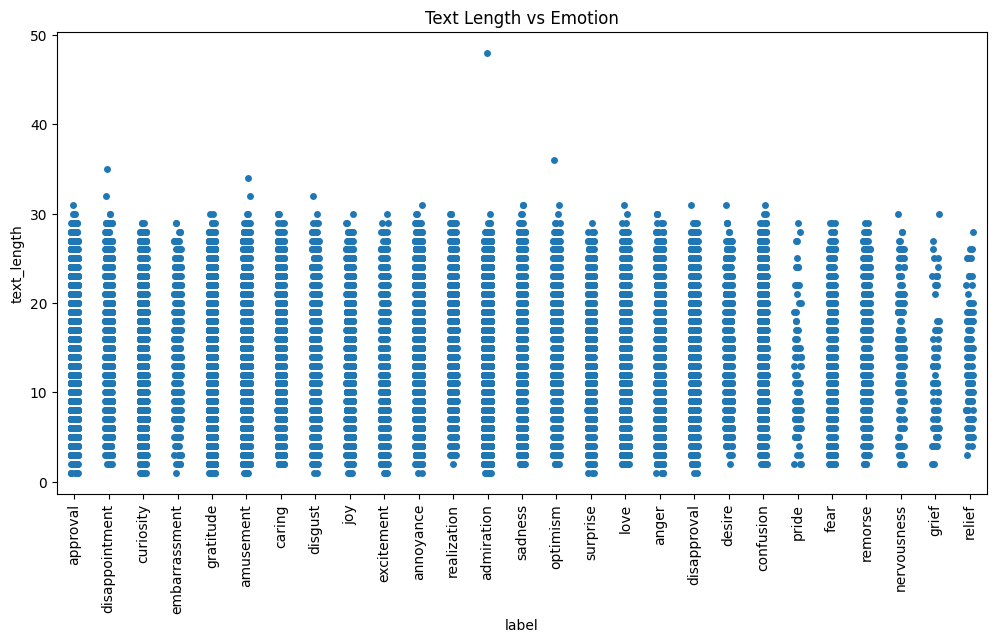

In [ ]:
# Step 8: Emotion Over Text Length

plt.figure(figsize=(12,6))
sns.stripplot(x='label', y='text_length', data=df_clean, jitter=True)
plt.xticks(rotation=90)
plt.title("Text Length vs Emotion")
plt.show()

In [ ]:
# Step 9: Rare Emotions

emotion_counts = df_clean['label'].value_counts()
rare_emotions = emotion_counts[emotion_counts < 200].index.tolist()
print("Rare Emotions:", rare_emotions)

Rare Emotions: ['nervousness', 'relief', 'pride', 'grief']


/tmp/ipython-input-871846313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment'] = df_clean['label'].map(sentiment_map)


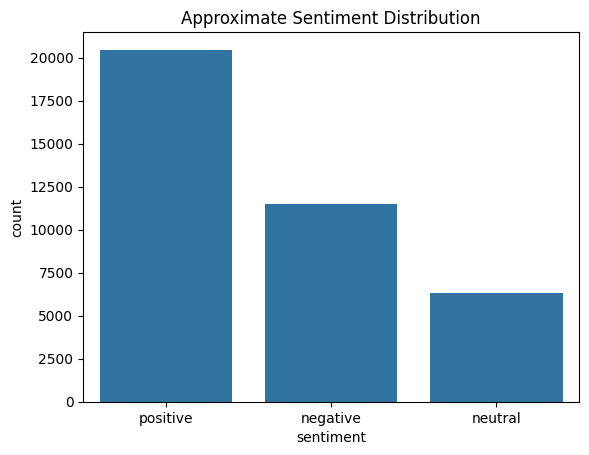

In [ ]:
# Step 10: Sentiment Overview

sentiment_map = {
    'joy':'positive', 'love':'positive','admiration':'positive','approval':'positive','optimism':'positive','pride':'positive','gratitude':'positive','excitement':'positive',
    'sadness':'negative','anger':'negative','disgust':'negative','fear':'negative','grief':'negative','remorse':'negative','annoyance':'negative','disappointment':'negative','embarrassment':'negative','nervousness':'negative','confusion':'neutral',
    'curiosity':'neutral','realization':'neutral','relief':'positive','desire':'neutral','amusement':'positive','caring':'positive','surprise':'neutral','disapproval':'negative'
}

df_clean['sentiment'] = df_clean['label'].map(sentiment_map)
sns.countplot(x='sentiment', data=df_clean)
plt.title("Approximate Sentiment Distribution")
plt.show()

## Exploratory Data Analysis (EDA) Results

- **Dataset:** 38,242 comments, 27 emotion classes  
- **Emotion Distribution:** Most common: joy, love, admiration; rare: nervousness, relief, pride, grief  
- **Comment Length:** Average ~21 words; mostly short with some longer ones  
- **Common Words:** im, just, like, love, dont, good, thats, thanks, really, people  
- **Top Words per Emotion:** joy: happy, im, glad, enjoy; sadness: sad, im, sorry, feel; anger: fuck, hate, fucking, just; fear: im, scared, afraid, terrible  
- **Text vs Emotion & Sentiment:** Positive emotions slightly longer; negative vary more. Positive emotions dominate overall. Some emotions correlated, e.g., sadness & grief, anger & annoyance


# 3. Model Development

In [ ]:
# Step 1: Prepare df_clean

texts = df_clean['clean_text'].tolist()
labels = df_clean['label'].tolist()

# encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)

# split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42
)

print(f"Training Samples: {len(X_train_texts)}, Test Samples: {len(X_test_texts)}")
print(f"Classes: {le.classes_}")

Training Samples: 30593, Test Samples: 7649
Classes: ['admiration' 'amusement' 'anger' 'annoyance' 'approval' 'caring'
 'confusion' 'curiosity' 'desire' 'disappointment' 'disapproval' 'disgust'
 'embarrassment' 'excitement' 'fear' 'gratitude' 'grief' 'joy' 'love'
 'nervousness' 'optimism' 'pride' 'realization' 'relief' 'remorse'
 'sadness' 'surprise']


In [ ]:
# Step 2: TF-IDF + Logistic Regression / SVM

# vectorize
tfidf_lr = TfidfVectorizer(max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_train_tfidf_lr = tfidf_lr.fit_transform(X_train_texts)
X_test_tfidf_lr = tfidf_lr.transform(X_test_texts)

# model choice
model_a = LogisticRegression(max_iter=3000, class_weight="balanced", C=1.5)

# train
model_a.fit(X_train_tfidf_lr, y_train)

# predict
y_pred_a = model_a.predict(X_test_tfidf_lr)

# evaluate
print(classification_report(y_test, y_pred_a, target_names=le.classes_))


                precision    recall  f1-score   support

    admiration       0.74      0.55      0.63       962
     amusement       0.80      0.71      0.75       514
         anger       0.53      0.50      0.52       377
     annoyance       0.35      0.18      0.24       519
      approval       0.42      0.27      0.33       654
        caring       0.37      0.57      0.45       230
     confusion       0.37      0.41      0.39       306
     curiosity       0.47      0.45      0.46       451
        desire       0.38      0.59      0.46       124
disappointment       0.26      0.31      0.29       230
   disapproval       0.39      0.47      0.43       405
       disgust       0.35      0.51      0.42       149
 embarrassment       0.34      0.52      0.41        63
    excitement       0.28      0.47      0.35       139
          fear       0.52      0.69      0.59       137
     gratitude       0.91      0.86      0.88       582
         grief       0.20      0.33      0.25  

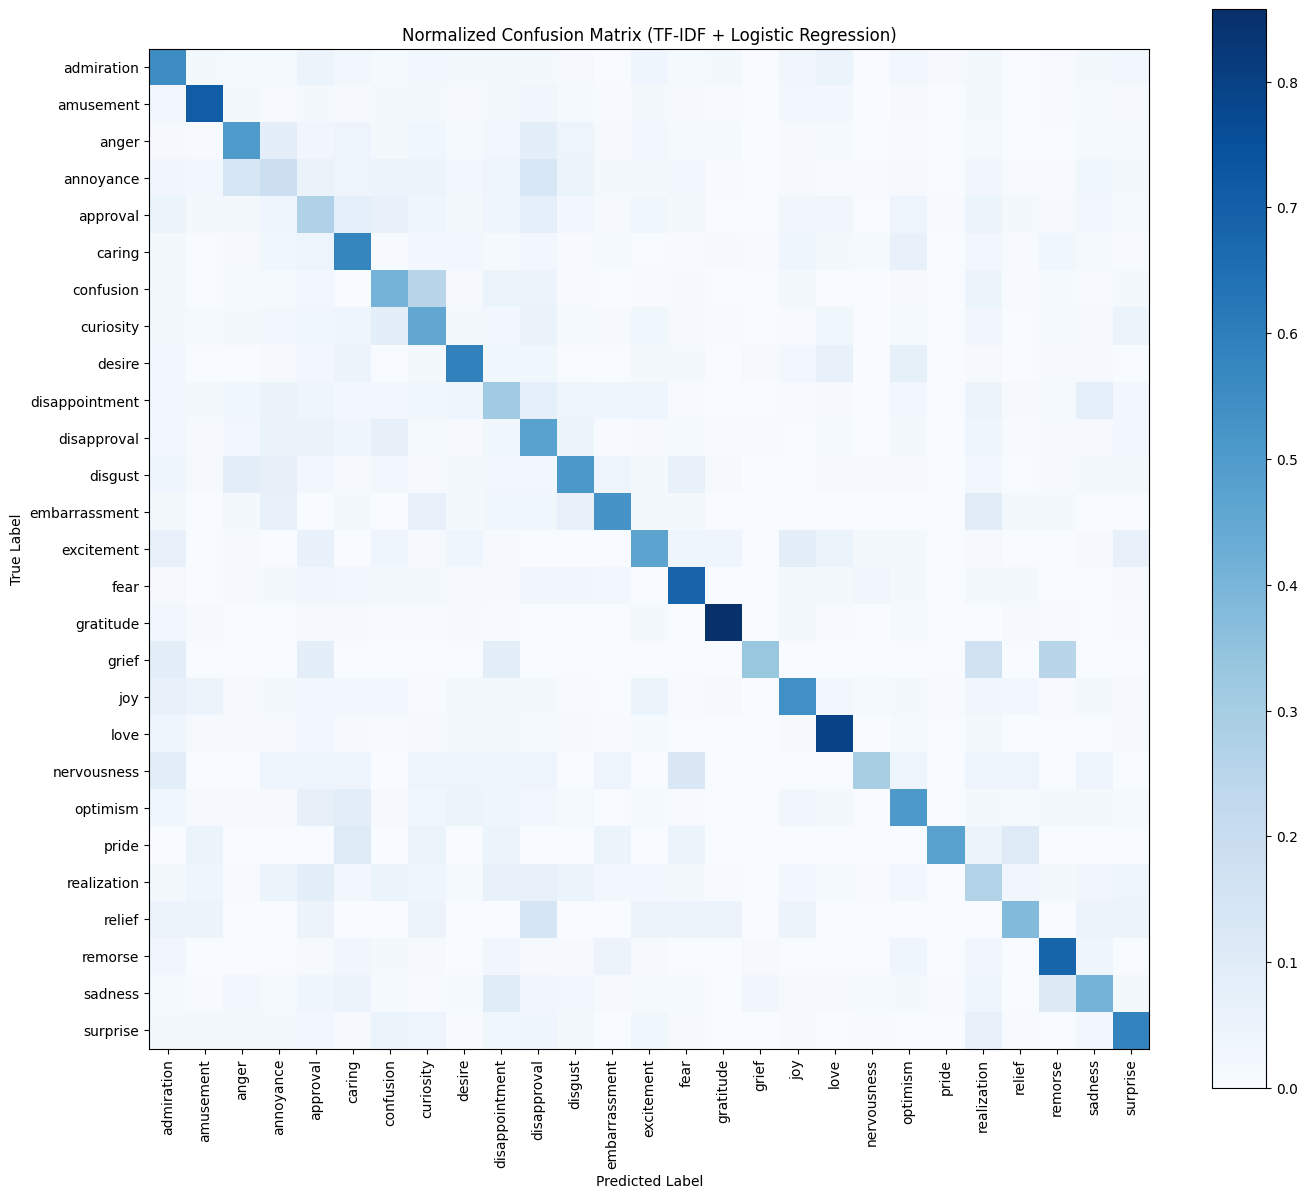

In [ ]:
# normalized confusion matrix (logistic)
cm = confusion_matrix(y_test, y_pred_a, normalize='true')

plt.figure(figsize=(14, 12))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')

plt.title("Normalized Confusion Matrix (TF-IDF + Logistic Regression)")
plt.colorbar(im)

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Step 3: TF-IDF + Linear Regression / SVM
tfidf_svm = TfidfVectorizer(max_features=10000)
X_train_tfidf_svm = tfidf_svm.fit_transform(X_train_texts)
X_test_tfidf_svm = tfidf_svm.transform(X_test_texts)

# model choice
model_b = LinearSVC(class_weight="balanced", max_iter=5000 )

# train
model_b.fit(X_train_tfidf_svm, y_train)

# predict
y_pred_svm = model_b.predict(X_test_tfidf_svm)

# evaluate
print(classification_report(
    y_test,
    y_pred_svm,
    target_names=le.classes_,
    zero_division=0
))

                precision    recall  f1-score   support

    admiration       0.69      0.57      0.63       962
     amusement       0.75      0.78      0.77       514
         anger       0.47      0.47      0.47       377
     annoyance       0.33      0.19      0.24       519
      approval       0.44      0.27      0.34       654
        caring       0.34      0.45      0.39       230
     confusion       0.30      0.31      0.31       306
     curiosity       0.35      0.31      0.33       451
        desire       0.35      0.46      0.40       124
disappointment       0.22      0.23      0.23       230
   disapproval       0.36      0.36      0.36       405
       disgust       0.35      0.46      0.40       149
 embarrassment       0.33      0.48      0.39        63
    excitement       0.23      0.37      0.29       139
          fear       0.53      0.74      0.61       137
     gratitude       0.88      0.89      0.89       582
         grief       0.18      0.25      0.21  

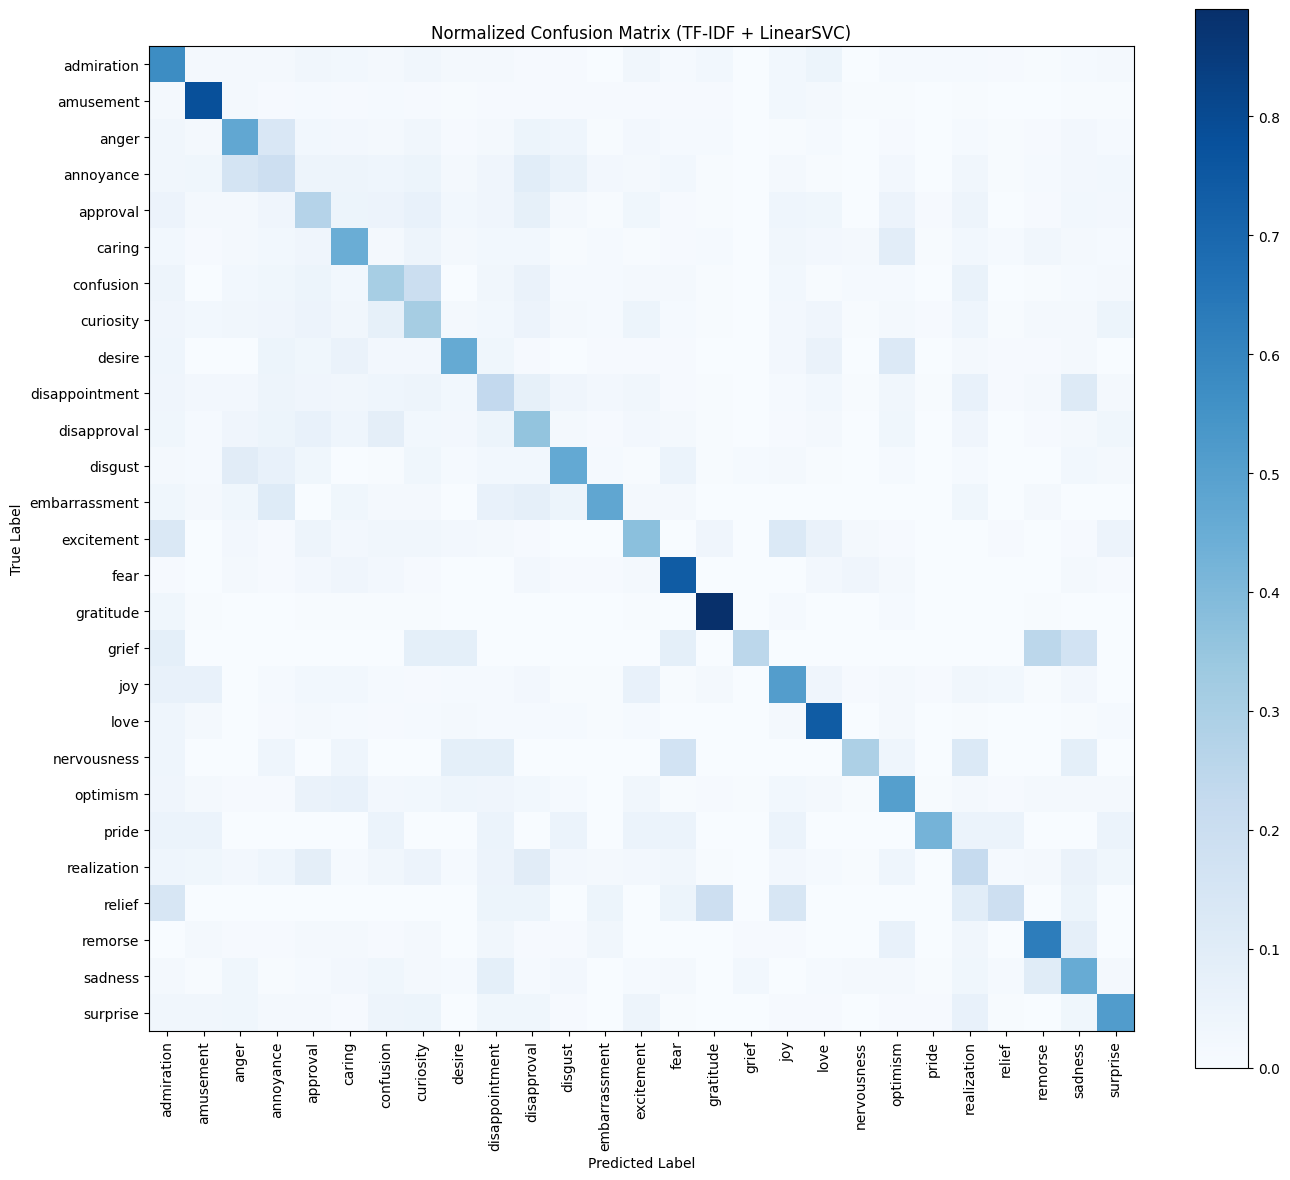

In [ ]:
# normalized confusion matrix (linear)
cm = confusion_matrix(y_test, y_pred_svm, normalize='true')

plt.figure(figsize=(14, 12))
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar(im)

tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)

plt.title("Normalized Confusion Matrix (TF-IDF + LinearSVC)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()

In [ ]:
# Step 4: GloVe Embeddings + Small Neural Network  (MODEL C)

# load GloVe
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings_index[word] = vector

def sentence_to_avg_vec(sentence):
    words = sentence.split()
    vecs = [embeddings_index[w] for w in words if w in embeddings_index]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_train_glove = np.array([sentence_to_avg_vec(s) for s in X_train_texts])
X_test_glove = np.array([sentence_to_avg_vec(s) for s in X_test_texts])

# one-hot
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

# MODEL C
model_c = Sequential([
    Dense(64, activation='relu', input_shape=(100,)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_c.fit(X_train_glove, y_train_oh, epochs=10, batch_size=32, validation_split=0.2)

y_pred_c = np.argmax(model_c.predict(X_test_glove), axis=1)
print("=== Model C: GloVe + Neural Network ===")
print(classification_report(y_test, y_pred_c, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1567 - loss: 2.9466 - val_accuracy: 0.2540 - val_loss: 2.5517
Epoch 2/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2681 - loss: 2.5243 - val_accuracy: 0.2739 - val_loss: 2.4672
Epoch 3/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2936 - loss: 2.4372 - val_accuracy: 0.2826 - val_loss: 2.4354
Epoch 4/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3087 - loss: 2.3832 - val_accuracy: 0.2997 - val_loss: 2.3857
Epoch 5/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3214 - loss: 2.3282 - val_accuracy: 0.3046 - val_loss: 2.3897
Epoch 6/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3203 - loss: 2.3282 - val_accuracy: 0.3027 - val_loss: 2.3700
Epoch 7/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3302 - loss: 2.3038 - val_accuracy: 0.3139 - val_loss: 2.3517
Epoch 8/10
765/765 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3332 - loss: 2.2878 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


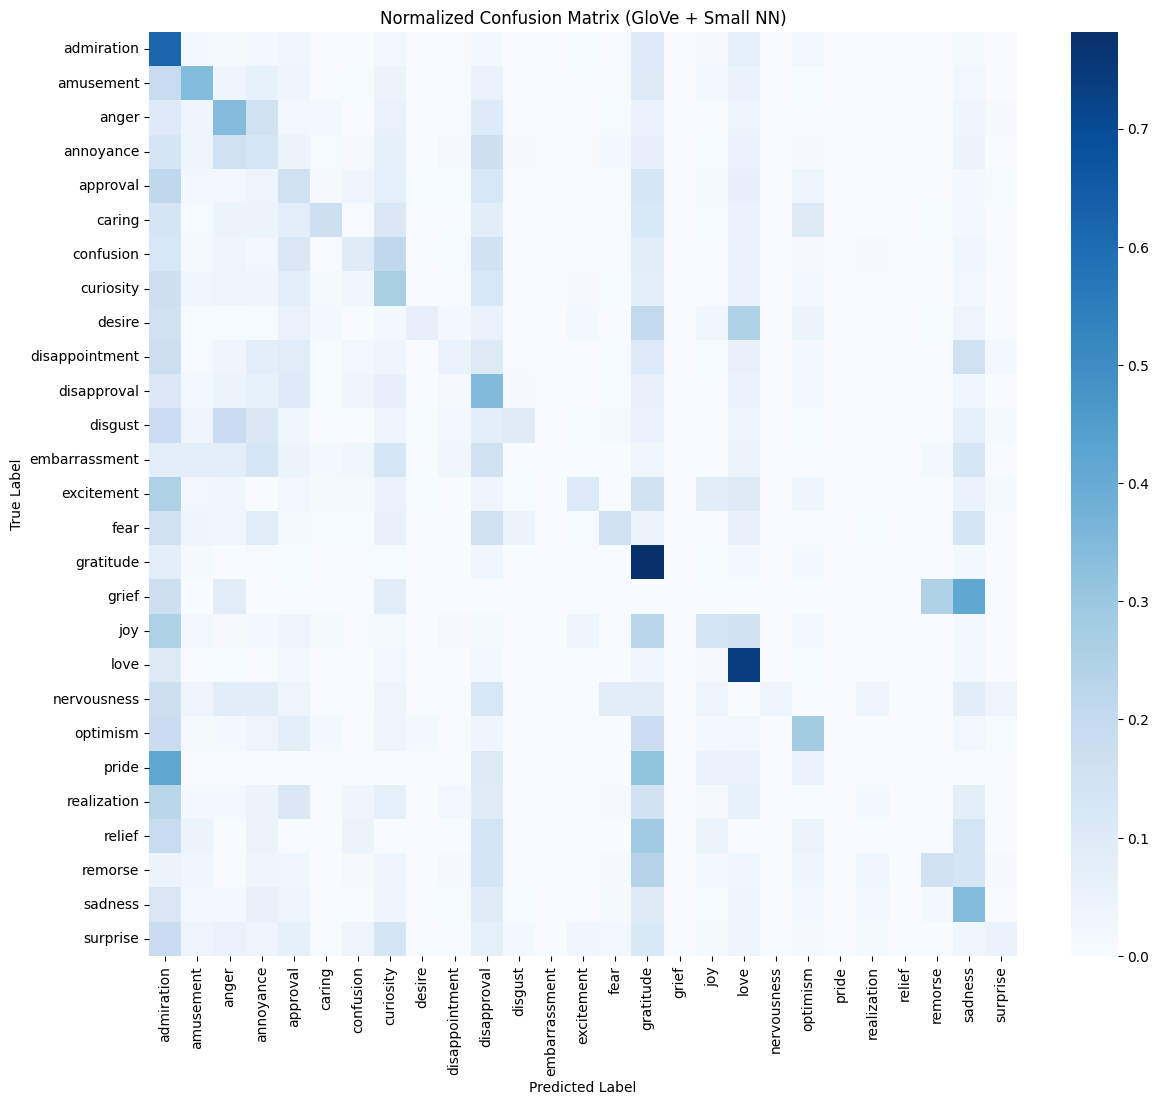

In [ ]:
# normalized confusion matrix (GloVe + Small NN)
cm = confusion_matrix(y_test, y_pred_c, normalize='true')
classes = le.classes_

plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=False, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.title("Normalized Confusion Matrix (GloVe + Small NN)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
# Step 5a: Comparing Models (via accuracy)

models = {
    "Logistic Regression": y_pred_a,
    "Linear SVM": y_pred_svm,
    "GloVe MLP": y_pred_c
}

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')  # macro = all classes equally
    print(f"{name}: Accuracy={acc:.3f}, Macro F1={f1:.3f}")

Logistic Regression: Accuracy=0.514, Macro F1=0.453
Linear SVM: Accuracy=0.487, Macro F1=0.412
GloVe MLP: Accuracy=0.324, Macro F1=0.199


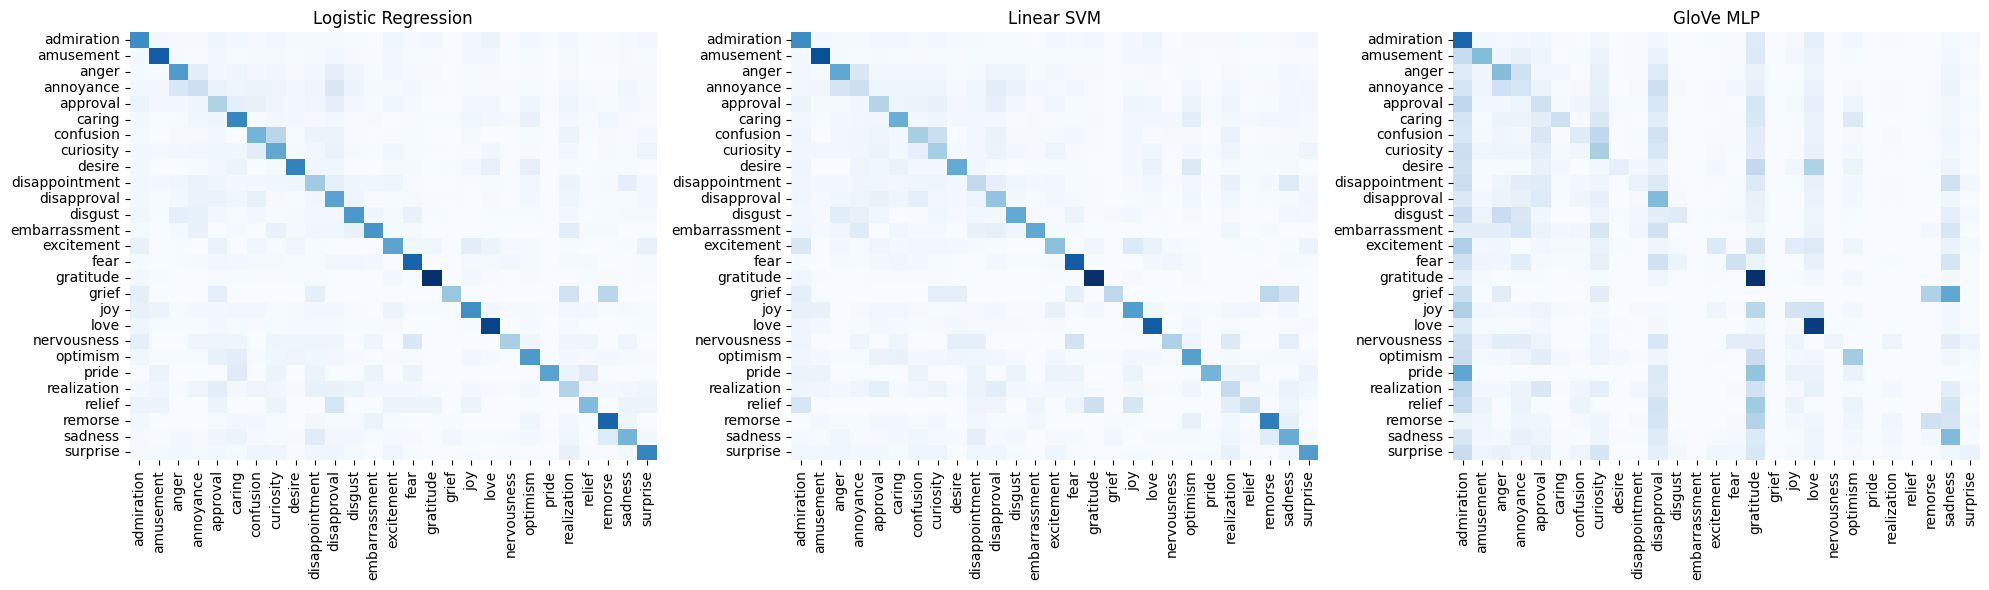

In [ ]:
# Step 5b: Comparing Models (via confusion matrix)

plt.figure(figsize=(20, 6))

for i, (name, preds) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, preds, normalize='true')
    plt.subplot(1, 3, i)
    sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
    plt.title(name)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


# 4. Response Generation Module

In [ ]:
# Step 0: Selecting the Model

best_model = model_a

In [ ]:
# Step 1: Define Model Prediction + Template Response Function

def generate_response(user_input):
    # clean text using the same cleaning function
    clean_input = clean_text_emotion(user_input)  # matches what you used during training

    # transform using the SAME TF-IDF vectorizer used to train model_a
    input_vec = tfidf_lr.transform([clean_input])  # do NOT fit a new vectorizer

    # predict using your trained logistic regression model
    pred_label_index = model_a.predict(input_vec)[0]
    pred_emotion = le.inverse_transform([pred_label_index])[0]

    # example reply
    reply = f"I'm sensing you feel {pred_emotion}. How can I help?"
    return pred_emotion, reply

In [ ]:
print("Welcome to your AI Wellness Assistant! Type 'quit' to exit.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        print("Goodbye! Take care. 😊")
        break

    pred_emotion, reply = generate_response(user_input) # generate response
    print(f"[Emotion: {pred_emotion}] AI: {reply}\n") # show predicted emotion and AI reply


Welcome to your AI Wellness Assistant! Type 'quit' to exit.

[Emotion: joy] AI: I'm sensing you feel joy. How can I help?

[Emotion: nervousness] AI: I'm sensing you feel nervousness. How can I help?

[Emotion: love] AI: I'm sensing you feel love. How can I help?

[Emotion: curiosity] AI: I'm sensing you feel curiosity. How can I help?

[Emotion: pride] AI: I'm sensing you feel pride. How can I help?

[Emotion: sadness] AI: I'm sensing you feel sadness. How can I help?

[Emotion: surprise] AI: I'm sensing you feel surprise. How can I help?

[Emotion: confusion] AI: I'm sensing you feel confusion. How can I help?

[Emotion: surprise] AI: I'm sensing you feel surprise. How can I help?

[Emotion: confusion] AI: I'm sensing you feel confusion. How can I help?

[Emotion: confusion] AI: I'm sensing you feel confusion. How can I help?

[Emotion: joy] AI: I'm sensing you feel joy. How can I help?

[Emotion: sadness] AI: I'm sensing you feel sadness. How can I help?

[Emotion: disappointment] A